In [1]:
from math import ceil
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

from huffman import *

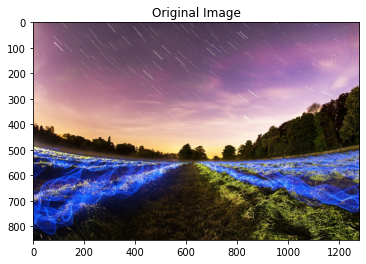

In [2]:
addr = 'photo.png'

# read image
im = mpimg.imread(addr) * 255.0
orginalImg = np.uint8(im)

plt.imshow(orginalImg)
plt.title('Original Image')
plt.show()

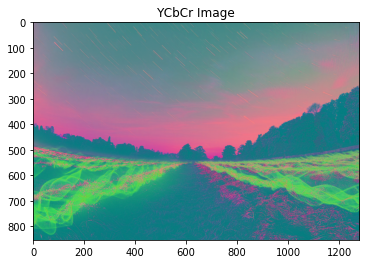

In [3]:
# convert RGB to YCrCb
# *** Part 1 ***
xform = np.array([[.299, .587, .114], [-.1687, -.3313, .5], [.5, -.4187, -.0813]])
YCbCr = im.dot(xform.T)
YCbCr[:,:,[1,2]] += 128
    
img = np.uint8(YCbCr)

plt.imshow(img)
plt.title('YCbCr Image')
plt.show()

In [4]:
h = len(img)
w = len(img[0])

y = np.zeros((h, w), np.float32) + img[:, :, 0]
cr = np.zeros((h, w), np.float32) + img[:, :, 1]
cb = np.zeros((h, w), np.float32) + img[:, :, 2]

total_bits = len(y) * len(y[0]) * 8 + len(cb) * len(cb[0]) * 8 + len(cr) * len(cr[0]) * 8

y = y - 128
cr = cr - 128
cb = cb - 128

# chroma subsampling 4:2:0
cr2 = cv2.boxFilter(cr, ddepth=-1, ksize=(2,2))
cb2 = cv2.boxFilter(cb, ddepth=-1, ksize=(2,2))
crSub = cr2[::2,::2]
cbSub = cb2[::2,::2]

In [5]:
Q_lum = np.array([[16, 11, 10, 16, 24, 40, 51, 61],  # luminance quantization table
                [12, 12, 14, 19, 26, 58, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]])

Q_chrom = np.array([[17, 18, 24, 47, 99, 99, 99, 99],  # chrominance quantization table
                [18, 21, 26, 66, 99, 99, 99, 99],
                [24, 26, 56, 99, 99, 99, 99, 99],
                [47, 66, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99]])

In [6]:
# *** Part 2 ***
wsize = len(Q_lum)
            
c_w, c_l = ceil(len(cbSub[0]) / wsize) * wsize, ceil(len(cbSub) / wsize) * wsize

if (len(cbSub[0]) % wsize == 0) and (len(cbSub) % wsize == 0):
    new_cr = crSub.copy()
    new_cb = cbSub.copy()
else:
    new_cr = np.zeros((c_l, c_w))
    new_cb = np.zeros((c_l, c_w))
    for i in range(len(crSub)):
        for j in range(len(crSub[0])):
            new_cr[i, j] += crSub[i, j]
            new_cb[i, j] += cbSub[i, j]
            

y_w, y_l = ceil(len(y[0]) / wsize) * wsize, ceil(len(y) / wsize) * wsize

if (len(y[0]) % wsize == 0) and (len(y) % wsize == 0):
    new_y = y.copy()
else:
    new_y = np.zeros((y_l, y_w))
    
    for i in range(len(y)):
        for j in range(len(y[0])):
            new_y[i, j] += y[i, j]

In [7]:
y_dct, cr_dct, cb_dct = np.zeros((y_l, y_w)), np.zeros((c_l, c_w)), np.zeros((c_l, c_w))

horizontal_y = int(len(y_dct[0]) / wsize)
vertical_y = int(len(y_dct) / wsize) 

horizontal_c = int(len(cr_dct[0]) / wsize)
vertical_c = int(len(cr_dct) / wsize)  

In [8]:
for i in range(vertical_y):
    for j in range(horizontal_y):
        y_dct[i * wsize: i * wsize + wsize, j * wsize: j * wsize + wsize] = cv2.dct(new_y[i * wsize: i * wsize + wsize, j * wsize: j * wsize + wsize])

for i in range(vertical_c):
    for j in range(horizontal_c):
        cr_dct[i * wsize: i * wsize + wsize, j * wsize: j * wsize + wsize] = cv2.dct(new_cr[i * wsize: i * wsize + wsize, j * wsize: j * wsize + wsize])
        
        cb_dct[i * wsize: i * wsize + wsize, j * wsize: j * wsize + wsize] = cv2.dct(new_cb[i * wsize: i * wsize + wsize, j * wsize: j * wsize + wsize])

In [9]:
# *** Part 3 ***
y_q, cr_q, cb_q = np.zeros((y_l, y_w)), np.zeros((c_l, c_w)), np.zeros((c_l, c_w))

for i in range(vertical_y):
    for j in range(horizontal_y):        
        y_q[i * wsize: i * wsize + wsize, j * wsize: j * wsize + wsize] = np.ceil(y_dct[i * wsize: i * wsize + wsize, j * wsize: j * wsize + wsize] / Q_lum)

for i in range(vertical_c):
    for j in range(horizontal_c):        
        cr_q[i * wsize: i * wsize + wsize, j * wsize: j * wsize + wsize] = np.ceil(cr_dct[i * wsize: i * wsize + wsize, j * wsize: j * wsize + wsize] / Q_chrom)
        
        cb_q[i * wsize: i * wsize + wsize, j * wsize: j * wsize + wsize] = np.ceil(cb_dct[i * wsize: i * wsize + wsize, j * wsize: j * wsize + wsize] / Q_chrom)

In [10]:
# *** Part 6 ***
y_zigzag = np.zeros(((vertical_y * horizontal_y), wsize * wsize))
cr_zigzag = np.zeros(((vertical_c * horizontal_c), wsize * wsize))
cb_zigzag = np.zeros(((vertical_c * horizontal_c), wsize * wsize))

for i in range(vertical_y):
    for j in range(horizontal_y):        
        y_zigzag[i * j] += zigzag(y_q[i * wsize: i * wsize + wsize, j * wsize: j * wsize + wsize])
        
y_zigzag = y_zigzag.astype(np.int16)

for i in range(vertical_c):
    for j in range(horizontal_c):
        cr_zigzag[i * j] += zigzag(cr_q[i * wsize: i * wsize + wsize, j * wsize: j * wsize + wsize])
        
        cb_zigzag[i * j] += zigzag(cb_q[i * wsize: i * wsize + wsize, j * wsize: j * wsize + wsize])
        
cr_zigzag = cr_zigzag.astype(np.int16)
cb_zigzag = cb_zigzag.astype(np.int16)

In [11]:
y_encode = run_length_coding(y_zigzag)
y_freq_t = cal_frequency_table(y_encode)
y_huffman = calculate_huffman(y_freq_t)

cr_encode = run_length_coding(cr_zigzag)
cr_freq_t = cal_frequency_table(cr_encode)
cr_huffman = calculate_huffman(cr_freq_t)

cb_encode = run_length_coding(cb_zigzag)
cb_freq_t = cal_frequency_table(cb_encode)
cb_huffman = calculate_huffman(cb_freq_t)

In [12]:
# *** Part 7 ***
file = open("CompressedJPEG.txt", "w")

y_bits = ''
for value in y_encode:
    y_bits += y_huffman[value]

cr_bits = ''
for value in cr_encode:
    cr_bits += cr_huffman[value]

cb_bits = ''
for value in cb_encode:
    cb_bits += cb_huffman[value]
    
result = y_bits + "\n" + cr_bits + "\n" + cb_bits
print(result)

if file.writable():
    file.write(result)
file.close()

0100111000100101100100111000100101110100111000100110000100111000100110010100111000100110100100111000100110110100111000100111000100111000100111010001010111000111010011100000001000100111000100111100100111000100111110100111000000010101001101011010100100111000101000000000001110000010010011100010100001010011010110101101001110001010001001001110001010001101001101011010110000001110000011010011010110101000000011100001000000001110000101010011100010100100010011100000001100100111000000011101001110000000110010011100010100101010011100010100110010011100000010000000001110000010010011010110101100010101110001110100111000000100001001110001010011101001110000000101000000111000001101001110001010100000000011100001000000001110000011010011010110101001001110000001001010011100000010100001010111000111000101011100011100000011100001010000001110000101010011100010101001010011100010101010010011010110101001001110000001011010011100010101011000000111000001001001101011010110100111000000101101001110000001001010011100010101

In [13]:
new_total_bits = len(result) - 2
print("Compression Ratio = " + str(np.round(total_bits / new_total_bits, 1)))

Compression Ratio = 13.7


In [14]:
# Question 3
test = [8, 8, 34, 5, 10, 34, 6, 43, 127, 10, 10, 8, 10, 34, 10]

freq_t = cal_frequency_table(test)
test_huffman = calculate_huffman(freq_t)
print(test_huffman)

{10: '11', 8: '00', 34: '01', 43: '1010', 127: '1011', 5: '1000', 6: '1001'}


In [15]:
new_total_bits = 0
for s in test_huffman.values():
    new_total_bits += len(s)
    
total_bits = 15 * 8
print("Compression Ratio = " + str(np.round(total_bits / new_total_bits, 1)))

Compression Ratio = 5.5
